# Phrases

Process the phrases that appear in a relation.

## 1. Preprocess data

In [1]:
import copy
import json
import pandas as pd
import re

In [2]:
def read_data(file_name):
    json_data = []
    infile = open(file_name, "r")
    for line in infile:
        json_data.append(json.loads(line))
    infile.close()

In [3]:
def combine_data(json_data):
    combined_data = {}
    for data in json_data:
        key = f"{data['source_id']} {data['speech_id']} {data['paragraph_id']}"
        if key not in combined_data:
            combined_data[key] = copy.deepcopy(data)
        else:
            if len(data["data"]) != len(combined_data[key]["data"]):
                print("cannot happen")
            for label_data in data["label"]:
                if label_data not in combined_data[key]["label"]:
                    combined_data[key]["label"].append(label_data)
                    if combined_data[key]["label"][-1][1] > len(combined_data[key]["data"]):
                        combined_data[key]["label"][-1][1] = len(combined_data[key]["data"])
    for key in combined_data:
        for label_data in combined_data[key]["label"]:
            label_data.append(combined_data[key]["data"][label_data[0]:label_data[1]])
    return combined_data

In [6]:
def tokenize(combined_data):
    for data_key in combined_data:
        paragraph = combined_data[data_key]["data"]
        tokens = {}
        token_id = -1
        for i in range(0, len(paragraph)):
            if token_id < 0 and paragraph[i] == " ":
                next
            elif token_id < 0:
                token_id = i
                tokens[token_id] = paragraph[i]
            elif paragraph[i] == " ":
                token_id = -1
            elif re.search("[.,?!]", paragraph[i]):
                tokens[i] = paragraph[i]
            else:
                tokens[token_id] += paragraph[i]
        labels = {}
        for label_key in tokens:
            labels[label_key] = "O"
        for label in combined_data[data_key]["label"]:
            if label[2] == 'Content_Relation_Explanation':
                first = True
                for label_key in labels:
                    if label_key >= label[0] and label_key < label[1]:
                        if first:
                            labels[label_key] = "B-E"
                            first = False
                        else:
                            labels[label_key] = "I-E"
        combined_data[data_key]["tokens"] = [ (tokens[label_key], labels[label_key]) for label_key in labels ]
    return combined_data

In [7]:
json_data = read_data("../data/femke.jsonl")
combined_data = combine_data(json_data)
combined_data = tokenize(combined_data)

## 2. Roberta Named Entity Recogntion by Erik Novak

Source: https://www.kaggle.com/eriknovak/pytorch-roberta-named-entity-recognition

In [8]:
import sys
!{sys.executable} -m pip install datasets

In [9]:
# visualization libraries
import matplotlib.pyplot as plt
import numpy as np

# pytorch libraries
import torch # the main pytorch library
import torch.nn as nn # the sub-library containing Softmax, Module and other useful functions
import torch.optim as optim # the sub-library containing the common optimizers (SGD, Adam, etc.)

# huggingface's transformers library
from transformers import RobertaForTokenClassification, RobertaTokenizer

# huggingface's datasets library
from datasets import load_dataset, Dataset, DatasetDict, Features, Value
from datasets.features import Sequence, ClassLabel

# HACK for transformers kernel: in ~/projects/filterbubble/transformers/venv3/lib/python3.7/site-packages/datasets/load.py replaced line 284: huggingface_hub.hf_api.DatasetInfo by ""

# the tqdm library used to show the iteration progress
import tqdm
tqdmn = tqdm.notebook.tqdm

In [10]:
roberta_version = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(roberta_version)

In [11]:
project_data = { 'id': [], 'tokens': [], 'ner_tags': [] }
ner_tag_ids = {}
for key in combined_data:
    tokens = []
    ner_tags = []
    for i in range(0, len(combined_data[key]['tokens'])):
        if combined_data[key]['tokens'][i][1] not in ner_tag_ids:
            ner_tag_ids[combined_data[key]['tokens'][i][1]] =  len(ner_tag_ids)
        tokens.append(combined_data[key]['tokens'][i][0])
        ner_tags.append(ner_tag_ids[combined_data[key]['tokens'][i][1]])
    project_data['id'].append(str(len(project_data['id'])))
    project_data['tokens'].append(tokens)
    project_data['ner_tags'].append(ner_tags)

In [12]:
features_id = Value('string')
features_tokens = Sequence(Value('string'))
features_ner_tags = Sequence(ClassLabel(names=list(ner_tag_ids.keys())))
features = Features({"id": features_id, "tokens": features_tokens, "ner_tags": features_ner_tags })

In [13]:
project_data_converted = DatasetDict({ "train": Dataset.from_dict(project_data, features=features)} )

In [14]:
num_labels = project_data_converted["train"].features['ner_tags'].feature.num_classes

In [15]:
def add_encodings(example):
    encodings = tokenizer(example['tokens'], truncation=True, padding='max_length', is_split_into_words=True)
    labels = example['ner_tags'] + [0] * (tokenizer.model_max_length - len(example['ner_tags']))
    return { **encodings, 'labels': labels }

In [16]:
project_data_converted = project_data_converted.map(add_encodings)

In [17]:
project_data_converted.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [18]:
labels = project_data_converted['train'].features['ner_tags'].feature
label2id = { k: labels.str2int(k) for k in labels.names }
id2label = { v: k for k, v in label2id.items() }

In [19]:
model = RobertaForTokenClassification.from_pretrained(roberta_version, num_labels=num_labels)
model.config.id2label = id2label
model.config.label2id = label2id

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
model.train().to(device)
optimizer = optim.AdamW(params=model.parameters(), lr=1e-5)

In [36]:
n_epochs = 3
train_data = torch.utils.data.DataLoader(project_data_converted['train'], batch_size=4)

In [37]:
train_loss = []
for epoch in tqdmn(range(n_epochs)):
    current_loss = 0
    for i, batch in enumerate(tqdmn(train_data)):
        batch = { k: v.to(device) for k, v in batch.items() }
        outputs = model(**batch)
        loss = outputs[0]
        loss.backward()
        current_loss += loss.item()
        if i % 8 == 0 and i > 0:
            optimizer.step()
            optimizer.zero_grad()
            train_loss.append(current_loss / 32)
            current_loss = 0
    optimizer.step()
    optimizer.zero_grad()

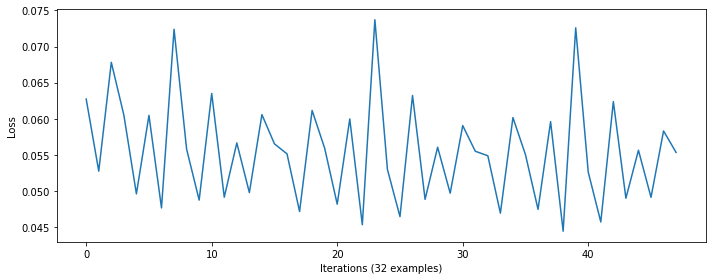

In [38]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(train_loss)
ax.set_ylabel('Loss')
ax.set_xlabel('Iterations (32 examples)')
fig.tight_layout()
plt.show()

In [39]:
model = model.eval()
test_data = torch.utils.data.DataLoader(project_data_converted['train'], batch_size=4)

In [40]:
confusion = torch.zeros(num_labels, num_labels)
found = 0
missed = 0
wrong = 0

for i, batch in enumerate(tqdmn(test_data)):
    with torch.no_grad():
        batch = { k: v.to(device) for k, v in batch.items() }
        outputs = model(**batch)
            
    s_lengths = batch['attention_mask'].sum(dim=1)
    for idx, length in enumerate(s_lengths):
        true_values = batch['labels'][idx][:length]
        pred_values = torch.argmax(outputs[1], dim=2)[idx][:length]
        for true, pred in zip(true_values, pred_values):
            confusion[true.item()][pred.item()] += 1
            if true.item() > 0:
                if pred.item() > 0:
                    found += 1
                else: 
                    missed += 1
            elif pred.item() > 0:
                wrong += 1

In [41]:
if found + wrong == 0:
    precision = 0.0
else:
    precision = found / (found + wrong)
recall = found / (found + missed)

print(f"precision: {precision}; recall: {recall}")

precision: 0.0; recall: 0.0


In [42]:
for i in range(num_labels):
    confusion[i] = confusion[i] / confusion[i].sum()

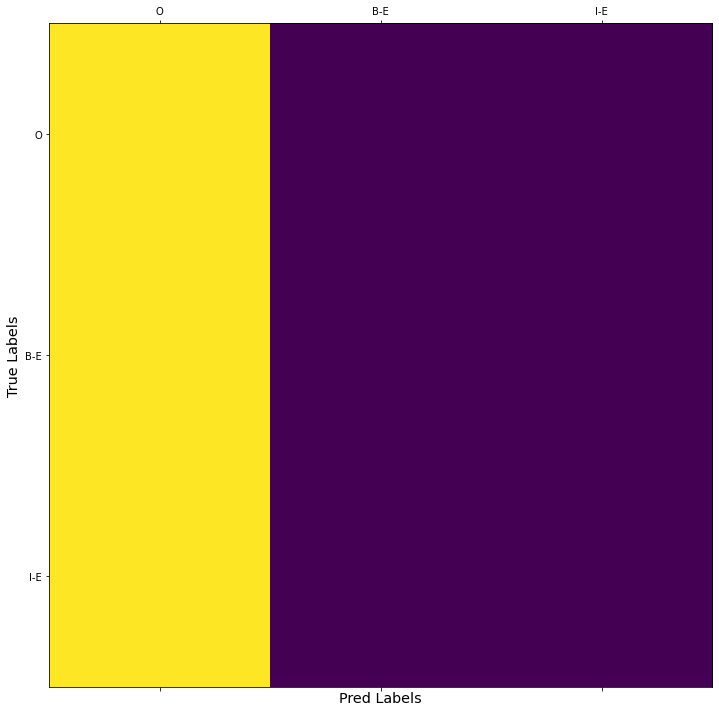

In [43]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(confusion.numpy())

labels = list(label2id.keys())
ids = np.arange(len(labels))

ax.set_ylabel('True Labels', fontsize='x-large')
ax.set_xlabel('Pred Labels', fontsize='x-large')

ax.set_xticks(ids)
ax.set_xticklabels(labels)

ax.set_yticks(ids)
ax.set_yticklabels(labels)

fig.tight_layout()
plt.show()

In [44]:
confusion.numpy()

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)